<!-- Assignment X - SS 2023 -->

# Monitoring and Hyper-parameters (10 points)

This notebook contains one of the assignments for the exercises in Deep Learning and Neural Nets 2.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility functions that should work without (too much) problems.
Please, do not alter this code or add extra import statements in your submission, unless explicitly allowed!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!

In this assignment, the main goal is to get familiar with neural network hyperparameter search.
More specifically, you will perform hyperparameter search on some real-world data.
To prepare you for the search, we will first look at how you can monitor the training progress.

In [4]:
import random
from pathlib import Path

import torch
import torchvision
from torch import nn, optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(1806)
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

%load_ext tensorboard

cuda


In [2]:
# google colab data management
import os.path

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    _home = 'gdrive/MyDrive/'
except ImportError:
    _home = '~'
finally:
    data_root = os.path.join(_home, '.pytorch')

print(data_root)

~/.pytorch


## Tracking Progress

Training a deep neural network with millions of parameters can cost quite some time.
E.g. Alexnet already requires roughly [225 hours][alexnet] (>1 week) of compute on a single GPU.
In order to make sure that the network is training as expected,
it is crucial to get some insights into how training progresses.
After all, you do not want to waste hundreds of hours of compute to find out
that training had already diverged in the first few minutes.
Therefore it is important to be able to monitor the training process.

[alexnet]: https://arxiv.org/abs/1404.5997

As a matter of fact, the `update` and `evaluate` functions
already implement some sort of ad hoc monitoring by providing the list of errors in a batch.
This list can be used to print the mean loss after every epoch
and can therefore be used to get an idea of how learning is progressing.
This specific implementation of monitoring the loss is not very flexible, however,
since it is not possible to access the information before the epoch has finished.

Before we start, we will tackle the flexibility of monitoring the loss
by creating a separate `Tracker` class to keep track
of important steps and results during training.

In [3]:
class Tracker:
    """ Tracks useful information as learning progresses. """

    def __init__(self, *loggers: "Logger"):
        """
        Parameters
        ----------
        logger0, logger1, ... loggerN : Logger
            One or more loggers for logging training information.
        """
        self.epoch = 0
        self.update = 0
        self._tag = None
        self._losses = []
        self._summary = {}

        self.loggers = list(loggers)

    def start_epoch(self, count: bool = True):
        """ Start one iteration of updates over the training data. """
        if count:
            self.epoch += 1

        self._summary.clear()
        for logger in self.loggers:
            logger.on_epoch_start(self.epoch)

    def end_epoch(self):
        """ Wrap up one iteration of updates over the training data. """
        for logger in self.loggers:
            logger.on_epoch_end(self.epoch, **self._summary)

        return dict(self._summary)

    def start(self, tag: str, num_batches: int = None):
        """ Start a loop over mini-batches. """
        self._tag = tag
        self._losses.clear()
        for logger in self.loggers: # loops over minibatch
            logger.on_iter_start(self.epoch, self.update, self._tag, num_steps_expected=num_batches)

    def step(self, loss: float):
        """ Register the loss of a single mini-batch. """
        self._losses.append(loss)
        for logger in self.loggers:
            logger.on_iter_update(self.epoch, self.update, self._tag, loss=loss)

    def summary(self):
        """ Wrap up and summarise a loop over mini-batches. """
        losses = self._losses
        avg_loss = float("nan") if len(losses) == 0 else sum(losses) / len(losses)
        self._summary[self._tag] = avg_loss
        for logger in self.loggers:
            logger.on_iter_end(self.epoch, self.update, self._tag, avg_loss=avg_loss)

        return avg_loss

    def count_update(self):
        """ Increase the update counter. """
        self.update += 1
        for logger in self.loggers:
            logger.on_update(self.epoch, self.update)

This class provides the same functionality as the list that
you might have used in the current `update` and `evaluate` functions.
However, it also makes it possible to extend the functionality
of both functions without the need to interfere with existing code.

Note that there are libraries and frameworks out there that provide
(parts of) the functionality we will implement in what follows.
Two example frameworks that directly build on pytorch are
[pytorch-lightning](https://www.pytorchlightning.ai/)
and [pytorch ignite](https://pytorch.org/ignite/).

### Exercise 1: Combining Classes for Tracking (2 points)

You might not have noticed yet, but in assignment 2, a `Trainer` class was introduced.
The goal of this exercise is to extend this `Trainer` class to make use of the `Tracker`.

 > Update the `Trainer` class to make use of the `tracker` attribute (see `__init__`).
 > The functionality and outputs of the current implementation should be preserved.
 > Also, make sure to offload as much as possible to the `tracker`.
 > You will want to use every method of the `Tracker` class.

In [4]:
class Trainer:
    """ Class to organise learning and monitoring. """

    def __init__(self,
         model: nn.Module,
         criterion: nn.Module,
         optimiser: optim.Optimizer,
         tracker: Tracker = None,
    ):
        """
        Parameters
        ----------
        model : torch.nn.Module
            Neural Network that will be trained.
        criterion : torch.nn.Module
            Loss function to use for training.
        optimiser : torch.optim.Optimizer
            Optimisation strategy for training.
        tracker : Tracker, optional
            Tracker to keep track of training progress.
        """
        if tracker is None:
            tracker = Tracker()

        self.model = model
        self.criterion = criterion
        self.optimiser = optimiser

        self.tracker = tracker

    def state_dict(self):
        """ Current state of learning. """
        return {
            "model": self.model.state_dict(),
            "objective": self.criterion.state_dict(),
            "optimiser": self.optimiser.state_dict(),
            "num_epochs": self.tracker.epoch,
            "num_updates": self.tracker.update,
        }

    @property
    def device(self):
        """ Device of the (first) model parameters. """
        return next(self.model.parameters()).device

    @torch.no_grad()
    def evaluate(self, batches: DataLoader, tag: str = None):
        """
        One epoch of evaluating the network.

        Parameters
        ----------
        batches : DataLoader
            An iterator over mini-batches of data to use for updating.
        tag : str, optional
            Identification tag for tracking loss values.

        Returns
        -------
        avg_loss : float
            The average loss over all mini-batches.
        """
        self.model.eval()
        device = self.device

        # YOUR CODE HERE

        self.tracker.start(tag, len(batches)) # set loss = []

        for x, y in batches: # (x,y)=single batch
            x, y = x.to(device), y.to(device)

            logits = self.model(x)
            loss = self.criterion(logits, y)

            self.tracker.step(loss) # append loss list

        avg_loss = self.tracker.summary() # take average loss
        return avg_loss


    @torch.enable_grad()
    def update(self, batches: DataLoader, tag: str = None):
        """
        One epoch of updating the network.

        Parameters
        ----------
        batches : DataLoader
            An iterator over mini-batches of data to use for updating.
        tag : str, optional
            Identification tag for tracking loss values.

        Returns
        -------
        avg_loss : float
            The average loss over all mini-batches.
        """
        self.model.train()
        device = self.device

        # YOUR CODE HERE


        self.tracker.start(tag, len(batches)) # set loss = []

        for x, y in batches:

            x, y = x.to(device), y.to(device)

            logits = self.model(x)
            loss = self.criterion(logits, y)

            self.tracker.step(loss) # append loss list

            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()

        self.tracker.count_update() # count how many updates are done, increase by 1 when went
        # with optimizer through all batches. This is meant with an update counter by my internet research


        avg_loss = self.tracker.summary() # take average loss
        return avg_loss


    def train(self, train_batches, valid_batches=None, num_epochs: int = 1):
        """
        Train the network for multiple epochs.

        Parameters
        ----------
        train_batches : DataLoader
            The training data for updating the network.
        valid_batches : DataLoader, optional
            The validation data for estimating the generalisation performance.
        num_epochs : int, optional
            The number of epochs to train.

        Returns
        -------
        results : dict
            The average loss estimates after `num_epochs` epochs.

        """
        if valid_batches is None:
            valid_batches = ()

        # YOUR CODE HERE
        self.tracker.epoch = 0
        train_loss = self.evaluate(train_batches, 'train')
        valid_loss = self.evaluate(valid_batches, 'valid')

        summary_dict = {}

        for _ in range(num_epochs):

            self.tracker.start_epoch(count=True)

            train_loss = self.update(train_batches, 'train')
            valid_loss = self.evaluate(valid_batches, 'valid')

            summary_dict = self.tracker.end_epoch()

        return summary_dict # get the average loss values, train, valid, of the last epoch


In [5]:
# sanity check (and test setup)
from torchvision import transforms
mean, std = .1307, .3081
normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (std, ))
])

dataset = torchvision.datasets.FashionMNIST(data_root, train=False, transform=normalise, download=True)
loader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

conv_net = nn.Sequential(
    nn.Conv2d(1, 8, 5), nn.MaxPool2d(3), nn.ELU(),
    nn.Conv2d(8, 16, 7), nn.ELU(),
    nn.Flatten(),
    nn.Linear(64, 10),
)

trainer = Trainer(
    model=conv_net.to(device),
    criterion=nn.CrossEntropyLoss(reduction="sum"),
    optimiser=optim.Adam(conv_net.parameters(), lr=1e-2),
)

In [6]:
# Test Cell: do not edit or delete!
results = trainer.train(loader, loader, num_epochs=0)
assert trainer.tracker.epoch == 0, (
    f"ex1: initial evaluation epoch should not be counted, but tracker counted {trainer.tracker.epoch} epoch(s) (-0.5 points)"
)

In [7]:
# Test Cell: do not edit or delete!
results = trainer.train(loader, loader)
assert trainer.tracker.epoch == 1, (
    f"ex1: expected tracker to have counted 1 epoch, but found {trainer.tracker.epoch} (-0.5 points)"
)

In [8]:
# Test Cell: do not edit or delete!
assert "train" in results, "ex1: could not find training loss in results (-0.5 points)"
assert "valid" in results, "ex1: could not find validation loss in results (-0.5 points)"

In [9]:
# Test Cell: do not edit or delete!
results = trainer.evaluate(loader, tag="extra")

## Logging Tracked Information

In its simplest form, a `Tracker` only keeps track of what happens in an epoch.
It knows about the loss values for each mini-batch,
but also how many epochs and updates already happened.
However, as mentioned earlier, a lot of features can be added to the `Tracker`.

Most notably, we can use the `Tracker` to store certain information during training.
Thus far, loss information has been collected to compute the average and is then discarded.
In order to revisit this information later, it can be written to a file, or _logged_.

For this purpose, we will use the interface provided by the `Logger` class (below).
This way, different types of information can be logged in a flexible way.
Luckily the `Tracker` class already provides everything that is necessary
to work with loggers to monitor whatever we need during learning.

In [5]:
class Logger:
    """ Extracts and/or persists tracker information. """

    def __init__(self, path: str = None):
        """
        Parameters
        ----------
        path : str or Path, optional
            Path to where data will be stored.
        """
        path = Path("run") if path is None else Path(path)
        self.path = path.expanduser().resolve()

    def on_epoch_start(self, epoch: int, **kwargs):
        """Actions to take on the start of an epoch."""
        pass

    def on_epoch_end(self, epoch: int, **kwargs):
        """Actions to take on the end of an epoch."""
        pass

    def on_iter_start(self, epoch: int, update: int, tag: str, **kwargs):
        """Actions to take on the start of an iteration."""
        numb_batches = kwargs['num_steps_expected']
        pass

    def on_iter_update(self, epoch: int, update: int, tag: str, **kwargs):
        """Actions to take when an update has occurred."""
        pass

    def on_iter_end(self, epoch: int, update: int, tag: str, **kwargs):
        """Actions to take on the end of an iteration."""
        pass

    def on_update(self, epoch: int, update: int):
        """Actions to take when the model is updated."""
        pass

### Exercise 2: Progress bar (1 point)

Monitoring the loss early on during training can be useful
to check whether things are working as expected.
In combination with an indication of progress in training,
expectations can be properly managed early on.

 > Create a logger that produces some sort of progress bar for each epoch.
 > The progress bar should show the current epoch, the current trainnig stage (tag) and the current loss value.
 > Moreover, it should print a short summary after each epoch, including the average loss for each tag.
 > Note that most of this information is passed through the `kwargs` in the `Logger` methods.

**Hint:** You probably want to make use of the [`tqdm` library](https://tqdm.github.io/docs/tqdm/) to manage the progress bar.

In [6]:
class ProgressBar(Logger):
    """Log progress of epoch using a progress bar."""

    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        self.numb_batches = 0
        self.p_bar = None
        self.update_between_batches = 0


    # TODO: implement any logger method you like/need


    def on_iter_start(self, epoch, update, tag, **kwargs):
      if epoch > 0:
        self.numb_batches = kwargs['num_steps_expected']

    def on_iter_update(self, epoch, update, tag, loss, **kwargs):
      if epoch > 0:

        self.update_between_batches += 1 # we count the single batches here. 'update' only counts
        # the number of called training processes over epochs

        self.p_bar = tqdm(total=self.numb_batches, desc='batch progress')
        self.p_bar.update(self.update_between_batches)
        string = 'current epoch: '+ str(epoch) +' current tag: ' + str(tag) + ' current loss: ' + str(loss.item())
        self.p_bar.set_postfix_str(s=string,refresh=True)

        if self.update_between_batches == self.numb_batches:
            self.p_bar.close()

    def on_iter_end(self, epoch: int, update: int, tag: str, **kwargs):
      self.update_between_batches = 0

    def on_epoch_end(self, epoch, **kwargs):

      keys = list(kwargs.keys())
      print('Average losses:', f'{keys[0]}: ', kwargs[keys[0]].item(), f'{keys[1]}: ', kwargs[keys[1]].item())


In [ ]:
# sanity check (and test setup)
progress = ProgressBar()
trainer.tracker.loggers = [progress]
trainer.train(loader, loader, num_epochs=5)

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

Average losses: train:  699.9246826171875 valid:  618.0352783203125


batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

Average losses: train:  578.4266357421875 valid:  526.2444458007812


batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

Average losses: train:  511.13116455078125 valid:  481.08538818359375


batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

Average losses: train:  462.04876708984375 valid:  435.9231872558594


batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

batch progress:   0%|          | 0/10 [00:00<?, ?it/s]

Average losses: train:  425.76275634765625 valid:  404.4649353027344


{'train': tensor(425.7628, grad_fn=<DivBackward0>), 'valid': tensor(404.4649)}

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

### Exercise 3: Tensorboard (1 point)

[Tensorboard](https://www.tensorflow.org/tensorboard)
is a library that allows to track and visualise data during and after training.
Apart from scalar metrics, tensorboard can process distributions, images and much more.
It started as a part of tensorflow, but was then made available as a standalone library.
This makes it possible to use tensorboard for visualising pytorch data.
As a matter of fact, tensorboard is readily available in pytorch.
From [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html),
the `SummaryWriter` class can be used to track various types of data.

 > Create a Logger that makes use of the `Summarywriter` to monitor the loss with tensorboard.
 > On one hand, it should monitor the loss for every batch and both modes using `<tag>/loss` as tag.
 > On the other hand, it should monitor the average losses after every stage, using `'<tag>/avg_loss'`.

In [6]:
class TensorBoard(Logger):
    """Log loss values to tensorboard."""

    def __init__(self, path: Path = None, every: int = 1):
        super().__init__(path)
        self.every = every
        # YOUR CODE HERE
        self.writer = SummaryWriter(log_dir=self.path)
        self.update_between_batches = 0
        self.numb_batches = 0


    def on_iter_start(self, epoch, update, tag, **kwargs):
      if epoch > 0:
        self.numb_batches = kwargs['num_steps_expected']

    def on_iter_update(self, epoch, update, tag, loss, **kwargs):
      self.update_between_batches += 1

      if self.update_between_batches % self.every == 0:
        self.writer.add_scalar(tag=f'{tag}/loss', scalar_value=loss,global_step=self.update_between_batches)


    def on_iter_end(self, epoch, update, tag, avg_loss, **kwargs):
      self.update_between_batches = 0


    def on_epoch_end(self, epoch: int, **kwargs):
      if epoch % self.every == 0:
        keys = list(kwargs.keys())
        self.writer.add_scalar(tag=f'{keys[0]}/avg_loss', scalar_value=kwargs[keys[0]].item(),global_step=epoch)
        self.writer.add_scalar(tag=f'{keys[1]}/avg_loss', scalar_value=kwargs[keys[1]].item(),global_step=epoch)


In [ ]:
%tensorboard --logdir run

Reusing TensorBoard on port 6007 (pid 27019), started 5:45:01 ago. (Use '!kill 27019' to kill it.)

In [ ]:
# sanity check (and test setup)
tb = TensorBoard()
trainer.tracker.loggers = [tb]
trainer.train(loader, loader, num_epochs=5)

2023-06-24 09:01:15.787926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 09:01:22.898199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-24 09:01:22.898978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-24 09:01:22.899065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

{'train': tensor(346.2998, grad_fn=<DivBackward0>), 'valid': tensor(325.5374)}

In [ ]:
# Test Cell: do not edit or delete!
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
path = next(tb.path.glob("events.out.tfevents.*"))
tb_data = EventAccumulator(str(path)).Reload()
tags = tb_data.Tags()["scalars"]

assert "train/loss" in tags, "ex3: could not find training loss (-0.5 points)"
assert "valid/loss" in tags, "ex3: could not find validation loss (-0.5 points)"

In [ ]:
# Test Cell: do not edit or delete!
assert "train/avg_loss" in tags, "ex3: could not find avg training loss (-0.5 points)"
assert "valid/avg_loss" in tags, "ex3: could not find avg validation loss (-0.5 points)"

### Exercise 4: Always have a Backup-plan (1 point)

Apart from logging metrics like e.g. loss and accuracy,
it can often be useful to create a backup (or checkpoint) of training progress.
After all, you do not want hours of training to get lost
due to a programming error in a print statement at the end of your code.
This idea can also be useful to implement some form of early-stopping.
However, we will ignore that for now.

 > Implement a logger that saves the state of the trainer every few epochs.
 > For the sake of convention, use the `.pth` extension for storing these backups.

**Hint:** you may want to raise a [`warning`](https://docs.python.org/3/library/warnings.html#available-functions) if no trainer has been attached.

In [7]:
class Backup(Logger):

    DEFAULT_FILE = "backup.pth"

    def __init__(self, path: Path = None, every: int = 1):
        super().__init__(path)
        self.trainer = None
        self.every = every

        if self.path.is_dir() or not self.path.suffix:

            self.path = self.path / self.DEFAULT_FILE

        self.path.parent.mkdir(exist_ok=True, parents=True)


    def attach_trainer(self, trainer: Trainer):
        self.trainer = trainer

    def on_epoch_start(self, epoch: int, **kwargs):
        """Actions to take on the start of an epoch."""
        if self.trainer == None:
            raise UserWarning('There was no trainer attached!')
            #warnings.warn('There was no trainer attached!')# not working

    def on_epoch_end(self, epoch: int, **kwargs):
        print('epoch end of:',epoch) # I simply put it there for the final exercise.
        # It helped me tracking quite well.
        if epoch % self.every == 0:
            print('store in and as:',self.path)
            torch.save(self.trainer.state_dict(), self.path)
            print('stored')

In [ ]:
# sanity check (and test setup)
checkpoints = Backup(every=2)
trainer.tracker.loggers = [checkpoints]
checkpoints.attach_trainer(trainer)
trainer.train(loader, loader, num_epochs=4)
trainer.tracker.epoch

KeyboardInterrupt: 

In [ ]:
# Test Cell: do not edit or delete!
print(torch.load(checkpoints.path)["num_epochs"])

In [ ]:
# clean up checkpoints and tensorboard logs
! rm -r run

## Hyperparameter Search

Finding good hyperparameters for a model is a general problem in machine learning (or even statistics).
However, neural networks are (in)famous for their large number of hyperparameters.
To list a few: learning rate, batch size, epochs, pre-processing, layer count, neurons for each layer,
activation function, initialisation, normalisation, layer type, skip connections, regularisation, ...
Moreover, it is often not possible to theoretically justify a particular choice for a hyperparameter.
E.g. there is no way to tell whether $N$ or $N + 1$ neurons in a layer would be better, without trying it out.
Therefore, hyperparameter search for neural networks is an especially tricky problem to solve.

###### Manual Search

The most straightforward approach to finding good hyperparameters is to just
try out *reasonable* combinations of hyperparameters and pick the best model (using e.g. the validation set).
The first problem with this approach is that it requires a gut feeling as to what *reasonable* combinations are.
Moreover, it is often unclear how different hyperparameters interact with each other,
which can make an irrelevant hyperparameter look more important than it actually is or vice versa.
Finally, manual hyperparameter search is time consuming, since it is generally not possible to automate.

###### Grid Search

Getting a feeling for combinations of hyperparameters is often much harder than for individual hyperparameters.
The idea of grid search is to get a set of *reasonable* values for each hyperparameter individually
and organise these sets in a grid that represents all possible combinations of these values.
Each combinations of hyperparameters in the grid can then be run simultaneously,
assuming that so much hardware is available, which can speed up the search significantly.

###### Random Search

Since there are plenty of hyperparameters and each hyperparameters can have multiple *reasonable* values,
it is often not feasible to try out every possible combination in the grid.
On top of that, most of the models will be thrown away anyway because only the best model is of interest,
even though they might achieve similar performance.
The idea of random search is to randomly sample configurations, rather than choosing from pre-defined choices.
This can be interpreted as setting up an infinite grid and trying only a few --- rather than all --- possibilities.
Under the assumption that there are a lot of configurations with similarly good performance as the best model,
this should provide a model that performs very good with high probability for a fraction of the compute.

###### Bayesian Optimisation

Rather than picking configurations completely at random,
it is also possible to guide the random search.
This is essentially the premise of Bayesian optimisation:
sample inputs and evaluate the objective to find which parameters are likely to give good performance.

Bayesian optimisation uses a function approximator for the objective
and what is known as an *acquisition* function.
The function approximator, or *surrogate*,
has to be able to model a distribution over function values, e.g. a Gaussian Process.
The acquisition function then uses these distributions
to find where the largest improvements can be made, e.g. using the cdf.
For a more elaborate explanation of Bayesian optimisation,
see e.g. [this tutorial](https://arxiv.org/abs/1807.02811)

This approach is less parallellisable than grid or random search,
since it uses the information from previous runs to find good sampling regions.
However, often there are more configurations to be tried out than there are computing devices
and it is still possible to sample multiple configurations at each step with Bayesian Optimisation.
Also consider [this paper](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms) in this regard.

###### Neural Architecture Search

Instead of using Bayesian optimisation,
the problem of hyperparameter search can also be tackled by other optimisation algorithms.
This approach is also known as *Neural Architecture Search* (NAS).
There are different optimisation strategies that can be used for NAS,
but the most common are evolutionary algorithms and (deep) reinforcement learning.
Consider reading [this survey](http://jmlr.org/papers/v20/18-598.html)
to get an overview of how NAS can be used to construct neural networks.

## Real-World Deep Learning

In order to get a feeling for hyperparameter search,
you have to try it out on some real world example.
You can use the monitoring tools from previous exercises
to log performance and get a feeling for which hyperparameters work well.

###### Configuration

In order to keep track of what combinations have been tried in hyperparmeter search,
it is often useful to make use of configuration files.
Another key advantage of keeping configuration files is reproducability.
You can either write your own utilities (do not forget to include them here)
or make use of the classes below.

In [1]:
# See documentation for examples on how to use these classes and functions
from resources.config import Configuration, Grid, write_config

###### Task

The goal for this exercise will be to learn a representation of a 3D scene
from a set of plain images that are taken from different angles (see image below).
This representation can then be used to create images from arbitrary standpoints.
With some additional engineering, this could even result in something like
[an app][RealityScan] that allows you to upload objects to your computer.

[RealityScan]: https://www.epicgames.com/site/en-US/news/epic-games-introduces-realityscan-app-now-in-limited-beta

A single sample of data consists of a transformation matrix that describes
the position of the camera together with the corresponding image.
Eventually, the task consists of learning a function that maps
positions in space to an RGB color value and a density.
This mapping is typically referred to as a radiance field.

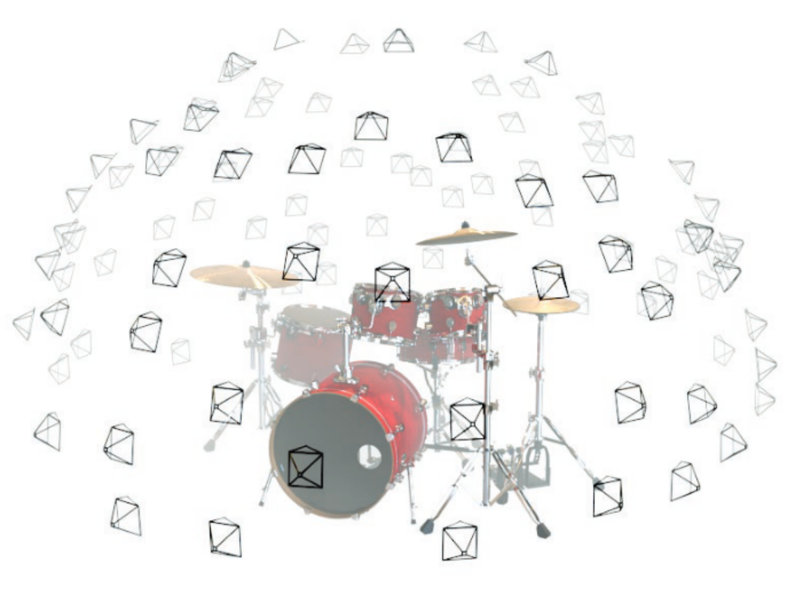

Each sample consists of a camera pose (input) and an image (target).
The camera pose is a 4x4 matrix specifying the position and orientation
of the camera in the 3D world of the object.
The image is a 800x800 RGB image of an inanimate object in the 3D world
that is taken from the corresponding camera perspective.

You can use the `SceneData` dataset for accessing two distinct datasets.
The constructor can be used to download and extract the ~250MB archives.
By default, the dataset will provide the drum kit data,
but also a scene with a chair has been included.
By default, the dataset will load the drum-kit images,
but this can be changed by setting `scene="chair"`.
The mean RGB intensities of the drum-kit images are `(0.1532, 0.1144, 0.0943)`
with standard deviations of `(0.2945, 0.2465, 0.2094)`, respectively.
For the chair images, the mean intensities are `(0.1319, 0.1404, 0.1006)`
with standard deviations of `(0.2766, 0.2846, 0.2185)`.
The dataset should act like a regular torchvision dataset,
i.e. the raw images are loaded as PIL images,
and you can use `torchvision.transforms` to take care of pre-processing.

In [12]:
from resources.dataset import SceneData
drums = SceneData(data_root, train=True, download=True)

Using downloaded and verified file: gdrive/MyDrive/.pytorch/DLNN2_2022_AX.zip
Extracting gdrive/MyDrive/.pytorch/DLNN2_2022_AX.zip to gdrive/MyDrive/.pytorch/DLNN2_2022_AX


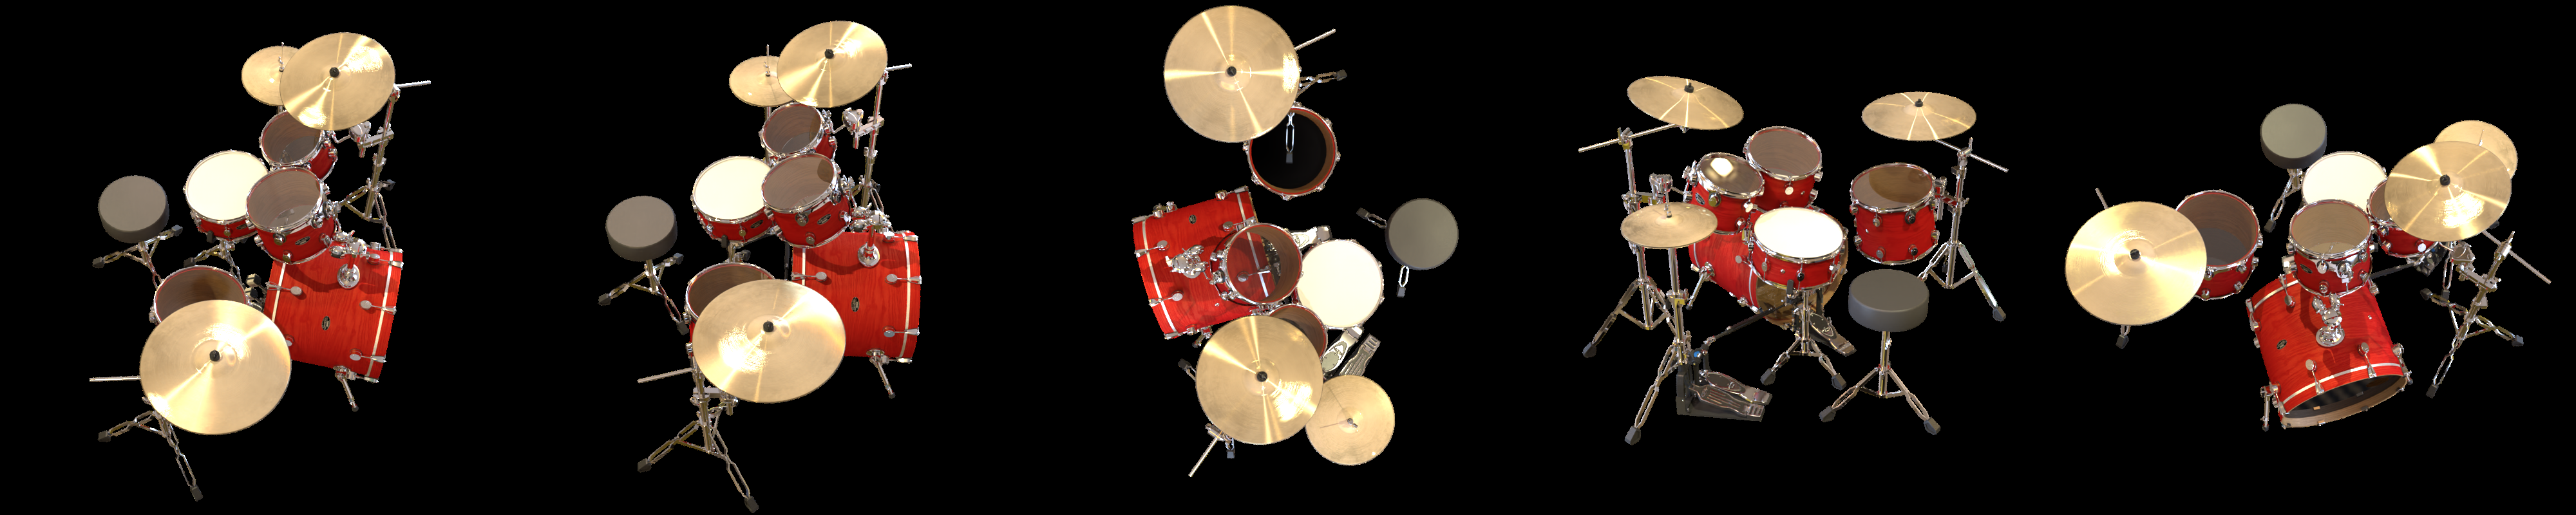

In [13]:
from PIL import Image
num_samples, (width, height) = 5, drums.img_size
img = Image.new("RGB", (width * num_samples, height))
for i in range(num_samples):
    _, _img = drums[i]
    img.paste(_img, (i * width, 0))
display(img, metadata={"width": "100%"})

###### Differential Rendering

To make the mapping from camera position to an actual image feasible,
a simple, differentiable rendering pipeline is used.
For this exercise, I provide you with a simple volumetric ray casting engine
that should be able to produce images from the radiance field.
Although the code is given, the rendering gives rise to additional hyperparameters.
Therefore, it might also be useful/necessary to tune some of the parameters.
You can read the documentation strings for details on the different parameters.

In [14]:
from resources.rendering import NeuralRenderer

ModuleNotFoundError: ignored

### Exercise 5: Student Gradient Descent (5 points)

Universities generally do not have the hardware to compete with industry.
In order to get similar levels of parallellisation,
universities make use of multiple students to try out hyperparameters
in a highly parallel fashion.

 > Find the best possible hyperparameters to train a network
 > on the data included with this assignment.
 > Use either grid search or random search
 > to test **at least five** different configurations.
 > Make sure to try out different learning rates and architecture variations,
 > since these are generally the most important hyperparameters.
 > Store the parameters and configuration for the best performing model,
 > since they will be part of your submission for the assignment.
 > An implementation of a simple radiance field network has been provided,
 > but you are free to choose any network of your likings.
 > Just make sure all code is included with this notebook.

**Hint:** use a subset of the data and a low number of epochs to get a feeling for what choices work well initially.

In [29]:
class Skip(nn.Module):
    """
    Skip connection as used in NeRFs.

    This is the same kind of skip connections as can be found in DenseNets.
    """

    def __init__(self, main: nn.Module):
        super().__init__()
        self.main = main

    def forward(self, x):
        y = self.main(x)
        return torch.cat([x, y], dim=-1)


class RadianceNetwork(nn.Module):
    """
    Neural network model for learning radiance fields.
    """

    @staticmethod
    def _build_mlp(*neurons: int):
        return nn.Sequential(*[
            nn.Sequential(nn.Linear(num_in, num_out), nn.ReLU())
            for num_in, num_out in zip(neurons[:-1], neurons[1:])
        ])

    def __init__(self, position_dim: int = 3, direction_dim: int = 3,
                 hidden_size: int = 128, num_layers: int = 3):
        """
        Parameters
        ----------
        position_dim: int, optional
            The dimensionality of the position encoding.
        direction_dim: int, optional
            The dimensionality of the direction encoding.
        hidden_size : int, optional
            Number of neurons in each hidden layer.
        num_layers : int, optional
            Number of total layers in the location network.
        """
        super().__init__()
        neurons1 = (position_dim, ) + (hidden_size, ) * (num_layers // 2)
        self.residual = Skip(self._build_mlp(*neurons1))

        num_left = num_layers - num_layers // 2 - 1
        neurons2 = (hidden_size, ) * (num_left - 1) + (hidden_size + 1, )
        self.location_mlp = self._build_mlp(hidden_size + position_dim, *neurons2)

        self.color_mlp = nn.Sequential(
            nn.Linear(hidden_size + direction_dim, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 3),
        )

        self.reset_parameters()

    def reset_parameters(self):
        def _initialisation(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Sequential) or isinstance(m, Skip):
                return
            elif sum(par.numel() for par in m.parameters()) > 0:
                raise ValueError(f"'{m.__class__.__name__}' module not initialised")

        self.residual.apply(_initialisation)
        self.location_mlp.apply(_initialisation)
        self.color_mlp.apply(_initialisation)

    def forward(self, position, direction):
        h1 = self.residual(position)
        h2 = self.location_mlp(h1)
        loc, log_density = h2[..., :-1], h2[..., -1]
        color = self.color_mlp(torch.cat([loc, direction], dim=-1))
        return color, log_density


def get_optimiser(parameters, algo='Adam', **kwargs):
    constructor = getattr(optim, algo)
    return constructor(parameters, **kwargs)

In [2]:
def build_search_space():
    grid = Grid()
    grid.add_option("dev", device)
    grid.add_option("num_epochs", 15)
    grid.add_option("img_size", (100, 100))

    # YOUR CODE HERE
    # as described above lr and network architecture should be modified:
    grid.add_options('lr', [1e-2,1e-3,1e-4])
    grid.add_options('hidden_size', [8,16,32]) # weak machine, smaller hidden sizes used
    grid.add_options('num_layers',[4,2,3])
    return grid

In [5]:
grid = build_search_space()
choices = random.sample(range(len(grid)), k=10)
len(grid), len(choices)

(27, 10)

In [18]:
%tensorboard --logdir gridsearch --reload_multifile true

Reusing TensorBoard on port 6006 (pid 2300), started 0:04:09 ago. (Use '!kill 2300' to kill it.)

<IPython.core.display.Javascript object>

In [32]:
def run(config: Configuration, path: Path):
    # YOUR CODE HERE

    # train here:
    init_grid = build_search_space()

    # get data and its batches:
    # use compose transforms ToTensor() to convert images into tensors

    target_trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize(config.img_size,antialias=True),torchvision.transforms.Normalize((0.1532, 0.1144, 0.0943),(0.2945, 0.2465, 0.2094))])

    drums_train = SceneData(data_root, train=True, download=True, target_transform=target_trans)

    # needed for our trainer class usage:
    train_dataloader = DataLoader(drums_train, batch_size=None,shuffle=True)
    # num_workers=4,

    drums_val = SceneData(data_root, train=False, download=True,target_transform=target_trans)

    val_dataloader = DataLoader(drums_val, batch_size=None, shuffle=True)#,num_workers=4)


    # Renderer with Radiance Net:
    NR = NeuralRenderer(network_type=RadianceNetwork, img_size=config.img_size,focal_length=1,#drums.focal_length,
                        pos_encodings=3, dir_encodings=3,
                        hidden_size=config.hidden_size, num_layers=config.num_layers).to(config.dev)

    # loss criterion:
    criterion = nn.MSELoss(reduction="mean").to(config.dev) #, nn.CrossEntropyLoss(reduction='mean').to(config.dev)

    # Optimizer:
    optimizer = get_optimiser(parameters=NR.parameters(), algo='Adam', lr=config.lr)

    # training:
    my_trainer = Trainer(model=NR, criterion=criterion, optimiser=optimizer)

    # Logging (reuse of previous exercises):
    # I commented out some the visualizing Loggers to save some computational power.
    # progress = ProgressBar()
    # tb = TensorBoard(path=path, every=1)
    checkpoints = Backup(every=config.num_epochs, path=path)
    checkpoints.trainer = my_trainer
    my_trainer.tracker.loggers = [checkpoints]#[progress, tb, checkpoints]
    checkpoints.attach_trainer(my_trainer)

    loss_dict = my_trainer.train(train_batches=train_dataloader,valid_batches=val_dataloader,num_epochs=config.num_epochs)



    return loss_dict


In [61]:
best_err, best_path = float('inf'), None
for idx in choices:
    try:
        path = Path("gridsearch") / f"config{idx:02d}"
        summary = run(grid[idx], path)
        val_err = summary["valid"]

        # YOUR CODE HERE

        # training process run
        if val_err < best_err:
            best_err = val_err
            best_path = path

    except (RuntimeError, FileExistsError) as err:
        import sys, traceback
        print(f"config {idx} failed to train", file=sys.stderr)
        traceback.print_exc()

print(f"best result: {best_err:.5f} -> {best_path}")
#best result: 0.32454 -> gridsearch/config09
#{dev: cpu, num_epochs: 15, img_size: (100, 100), lr: 0.01, hidden_size: 8, num_layers: 2}


Using downloaded and verified file: gdrive/MyDrive/.pytorch/DLNN2_2022_AX.zip
Extracting gdrive/MyDrive/.pytorch/DLNN2_2022_AX.zip to gdrive/MyDrive/.pytorch/DLNN2_2022_AX
Using downloaded and verified file: gdrive/MyDrive/.pytorch/DLNN2_2022_AX.zip
Extracting gdrive/MyDrive/.pytorch/DLNN2_2022_AX.zip to gdrive/MyDrive/.pytorch/DLNN2_2022_AX


KeyboardInterrupt: ignored